# LightGBM

### Установка необходимых зависимостей

In [3]:
# %pip install lightgbm

In [4]:
# %pip install optuna scikit-learn optuna-integration

In [5]:
# %pip install hyperopt

In [6]:
# %pip install scipy

## Импорты

In [28]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
import seaborn as sns
import joblib
import json

from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    f1_score
)

from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution
from optuna.samplers import TPESampler

import warnings

warnings.filterwarnings("ignore")

from datetime import timedelta

### Определение констант

In [8]:
TARGET_NAME = 'Response'
FILE_PATH = '../data_sources/train.csv' # 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'
CV_FOLDS = 2
RANDOM_STATE = 42
N_JOBS = -1

In [9]:
GENERAL_PARAMS = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "random_state": RANDOM_STATE,
    "n_jobs": N_JOBS,
    "verbosity": -1,
    "is_unbalance": True,
}

In [10]:
def time_function(func):
    """Decorator to time function execution"""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"\n[{time.strftime('%H:%M:%S')}] Запуск: {func.__name__}...")
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"[{time.strftime('%H:%M:%S')}] Завершено {func.__name__} через {timedelta(seconds=int(elapsed))}")
        return result
    return wrapper

In [11]:
class ThresholdFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01, other_name='OTHER'):
        self.threshold = threshold
        self.other_name = other_name
        self.freq_maps_ = {}
        self.columns_ = []

    def fit(self, X, y=None):
        self.columns_ = X.columns.tolist()
        
        for col in self.columns_:
            # Считаем частоты всех категорий
            value_counts = X[col].value_counts(normalize=True)
            
            # Определяем, какие категории встречаются достаточно часто
            common_categories = value_counts[value_counts >= self.threshold].index
            
            # Создаём маппинг для частотного кодирования
            freq_map = {}
            
            # Для частых категорий сохраняем их реальную частоту
            for cat in common_categories:
                freq_map[cat] = value_counts[cat]

            # Для редких категорий используем суммарную частоту
            other_categories = value_counts[value_counts < self.threshold].index
            other_freq = value_counts[other_categories].sum() if len(other_categories) > 0 else 0
            
            freq_map[self.other_name] = other_freq
            
            # Сохраняем маппинг
            self.freq_maps_[col] = freq_map
        
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        for col in self.columns_:
            if col not in X_copy.columns:
                continue
            
            # Создаём временную колонку для преобразований
            temp_col = X_copy[col].astype(str)
            
            # Группируем редкие категории в OTHER
            common_categories = list(self.freq_maps_[col].keys())
            common_categories.remove(self.other_name)
            
            # Заменяем редкие категории на OTHER
            temp_col = temp_col.where(
                temp_col.isin(common_categories), 
                other=self.other_name
            )
            
            # Применяем частотное кодирование
            encoded_values = temp_col.map(self.freq_maps_[col])
            
            # Заполняем пропуски (новые категории получают частоту OTHER)
            encoded_values = encoded_values.fillna(self.freq_maps_[col][self.other_name])
            
            # Заменяем исходную колонку
            X_copy[col] = encoded_values
        
        return X_copy

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return self.columns_
        return input_features

### Загрузка датасета

In [12]:
df = pd.read_csv(FILE_PATH, index_col='id')
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


<a id="fource"></a>
### Разделение датасета

In [13]:
df_sample = df.sample(n=1500000, random_state=RANDOM_STATE)

X = df_sample.drop(TARGET_NAME, axis=1)
y = df_sample[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1000000,
    test_size=500000,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True)}")

Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train: Response
0    0.876795
1    0.123205
Name: proportion, dtype: float64


### Предобработка признаков

In [14]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", ThresholdFrequencyEncoder(threshold=0.01, other_name='OTHER'), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [15]:
lgb.LGBMClassifier(**GENERAL_PARAMS)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### RandomizedSearchCV

In [31]:
@time_function
def run_randomized_search_cv():
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**GENERAL_PARAMS))
    ])
    
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    lgb_params = {
        "classifier__num_leaves": stats.randint(20, 100),
        "classifier__max_depth": stats.randint(3, 15),
        "classifier__learning_rate": stats.loguniform(0.001, 0.3),
        "classifier__n_estimators": stats.randint(100, 1000),
        "classifier__min_child_samples": stats.randint(10, 100),
        "classifier__subsample": stats.uniform(0.5, 0.5),
        "classifier__colsample_bytree": stats.uniform(0.5, 0.5),
        "classifier__reg_alpha": stats.loguniform(1e-8, 10.0),
        "classifier__reg_lambda": stats.loguniform(1e-8, 10.0),
        "classifier__min_split_gain": stats.uniform(0, 0.1),
    }

    random_search = RandomizedSearchCV(
        estimator=model_pipeline,
        param_distributions=lgb_params,
        n_iter=10,
        cv=cv,
        scoring="f1",
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        verbose=1,
    )

    random_search.fit(X_train, y_train)
    
    print("\nЛучшие параметры RandomizedSearchCV:")

    for key, value in random_search.best_params_.items():
        print(f"  {key}: {value}")
    print(f"Best CV score: {random_search.best_score_:.4f}")

    print(f"Сохранение лучших параметров RandomizedSearchCV")
    with open("best_params/best_params_light_gbm_randomized_search.json", "w") as f:
        json.dump(random_search.best_params_, f, indent=4)
    
    print(f"Сохранение модели с лучшими параметрами")
    joblib.dump(random_search.best_estimator_, f"models/lightgbm_random_search.pkl")

    print(f"Тренировка модели на тесте с лучшими параметрами")
    y_pred = random_search.best_estimator_.predict(X_test)
    y_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]

    print(f"Оценка модели c использованием RandomizedSearchCV")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(classification_report(y_test, y_pred))

    return sns.heatmap(
        confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues"
    )


[09:52:50] Запуск: run_randomized_search_cv...
Fitting 2 folds for each of 10 candidates, totalling 20 fits

Лучшие параметры RandomizedSearchCV:
  classifier__colsample_bytree: 0.7816441089227697
  classifier__learning_rate: 0.00900997135734756
  classifier__max_depth: 12
  classifier__min_child_samples: 62
  classifier__min_split_gain: 0.0230893825622149
  classifier__n_estimators: 191
  classifier__num_leaves: 79
  classifier__reg_alpha: 1.254134495897175e-07
  classifier__reg_lambda: 0.00028614897264046574
  classifier__subsample: 0.5171942605576092
Best CV score: 0.4477
Сохранение лучших параметров RandomizedSearchCV
Сохранение модели с лучшими параметрами
Тренировка модели на тесте с лучшими параметрами
Оценка модели c использованием RandomizedSearchCV
ROC-AUC: 0.8621
              precision    recall  f1-score   support

           0       0.98      0.71      0.82    438397
           1       0.30      0.89      0.45     61603

    accuracy                           0.73    500

<Axes: >

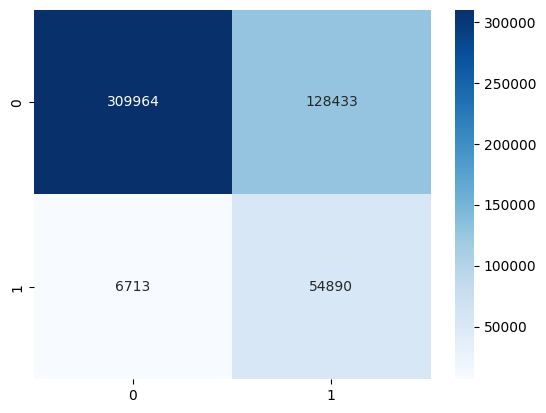

In [32]:
run_randomized_search_cv()

### Optuna

In [29]:
@time_function
def run_optuna_searchcv(n_trials=15):
    param_distributions = {
        "classifier__num_leaves": IntDistribution(20, 100),
        "classifier__max_depth": IntDistribution(3, 15),
        "classifier__learning_rate": FloatDistribution(0.001, 0.3, log=True),
        "classifier__n_estimators": IntDistribution(100, 1000),
        "classifier__min_child_samples": IntDistribution(10, 100),
        "classifier__subsample": FloatDistribution(0.5, 1.0),
        "classifier__colsample_bytree": FloatDistribution(0.5, 1.0),
        "classifier__reg_alpha": FloatDistribution(1e-8, 10.0, log=True),
        "classifier__reg_lambda": FloatDistribution(1e-8, 10.0, log=True),
        "classifier__min_split_gain": FloatDistribution(0, 0.1),
    }

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", lgb.LGBMClassifier(**GENERAL_PARAMS)),
    ])
    
    optuna_search = OptunaSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_trials=n_trials,
        cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
        scoring="f1",  # or "f1"
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        verbose=1,
        enable_pruning=False,
    )
    
    print(f"Starting OptunaSearchCV with {n_trials} trials...")
    optuna_search.fit(X_train, y_train)
    
    print("\nBest parameters from OptunaSearchCV:")
    for key, value in optuna_search.best_params_.items():
        print(f"  {key}: {value}")
    print(f"Best CV score: {optuna_search.best_score_:.4f}")
    
    print("Сохранение лучших параметров")
    with open("best_params/best_params_ligth_gbm_optuna_searchcv.json", "w") as f:
        json.dump(optuna_search.best_params_, f, indent=4)
    
    print("Сохранение лучшей модели")
    joblib.dump(optuna_search.best_estimator_, "models/lightgbm_optuna_searchcv.pkl")
    
    print("Оценка на тестовом наборе")
    y_pred = optuna_search.predict(X_test)
    y_pred_proba = optuna_search.predict_proba(X_test)[:, 1]
    
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(classification_report(y_test, y_pred))
    
    return sns.heatmap(
        confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues"
    )

[I 2025-12-18 09:33:16,995] A new study created in memory with name: no-name-520f2f5a-a006-4145-ac94-0377dbd5c42b



[09:33:16] Запуск: run_optuna_searchcv...
Starting OptunaSearchCV with 15 trials...


[I 2025-12-18 09:33:51,569] Trial 11 finished with value: 0.4302364608504423 and parameters: {'classifier__num_leaves': 95, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.04712495305674112, 'classifier__n_estimators': 119, 'classifier__min_child_samples': 46, 'classifier__subsample': 0.6216761049802728, 'classifier__colsample_bytree': 0.6954281585466107, 'classifier__reg_alpha': 2.3943845038013722, 'classifier__reg_lambda': 1.2509013813597148e-06, 'classifier__min_split_gain': 0.030078546452450207}. Best is trial 11 with value: 0.4302364608504423.
[I 2025-12-18 09:33:59,072] Trial 10 finished with value: 0.4331202051023152 and parameters: {'classifier__num_leaves': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.04317695115092463, 'classifier__n_estimators': 173, 'classifier__min_child_samples': 34, 'classifier__subsample': 0.6925164328163105, 'classifier__colsample_bytree': 0.9817742174643955, 'classifier__reg_alpha': 8.421108105775958e-06, 'classifier__reg


Best parameters from OptunaSearchCV:
  classifier__num_leaves: 24
  classifier__max_depth: 14
  classifier__learning_rate: 0.0014903760150452362
  classifier__n_estimators: 932
  classifier__min_child_samples: 47
  classifier__subsample: 0.6212574396548698
  classifier__colsample_bytree: 0.5848806911875916
  classifier__reg_alpha: 0.1310027094321249
  classifier__reg_lambda: 4.087506780781011e-05
  classifier__min_split_gain: 0.0004527202994435209
Best CV score: 0.4506
Сохранение лучших параметров
Сохранение лучшей модели
Оценка на тестовом наборе
ROC-AUC: 0.8574
              precision    recall  f1-score   support

           0       0.97      0.72      0.83    438397
           1       0.31      0.86      0.45     61603

    accuracy                           0.74    500000
   macro avg       0.64      0.79      0.64    500000
weighted avg       0.89      0.74      0.78    500000

[09:38:50] Завершено run_optuna_searchcv через 0:05:34


<Axes: >

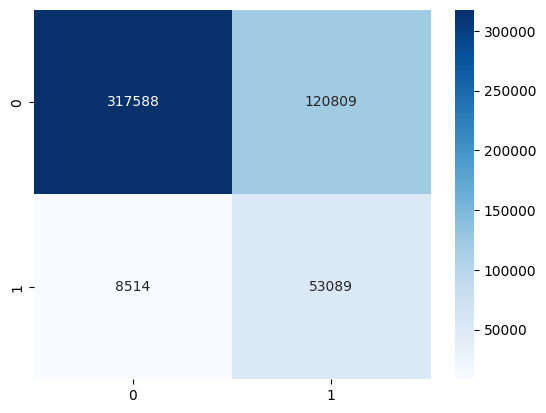

In [30]:
run_optuna_searchcv()